In [2]:
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd

[1.950e-03 2.930e-03 3.910e-03 5.860e-03 7.810e-03 1.172e-02 1.562e-02
 2.344e-02 3.125e-02 4.688e-02 6.250e-02 9.375e-02 1.250e-01 1.875e-01
 2.500e-01 3.750e-01 5.000e-01 7.500e-01 1.000e+00 1.500e+00 2.000e+00
 3.000e+00 4.000e+00 6.000e+00 8.000e+00 1.200e+01 1.600e+01 2.400e+01
 3.200e+01 4.800e+01 6.400e+01 9.600e+01 1.280e+02 1.920e+02 2.560e+02
 3.840e+02 5.120e+02 7.680e+02 1.024e+03 1.536e+03 2.048e+03]
[ 1.25966667  1.26033333  1.25933333  1.25933333  1.271       1.271
  1.26066667  1.26933333  1.26833333  4.424       4.424       4.42233333
  4.422       4.42066667  4.42533333  5.253       5.27066667  6.40666667
  9.15166667 18.905      20.99766667 20.848      20.783      20.69966667
 20.97333333 21.139      20.97433333 26.876      40.04066667 53.22766667
 57.831      57.20566667 58.32266667 61.76966667 66.36066667 61.348
 61.33933333 62.53533333 62.40733333 63.363      62.77633333]


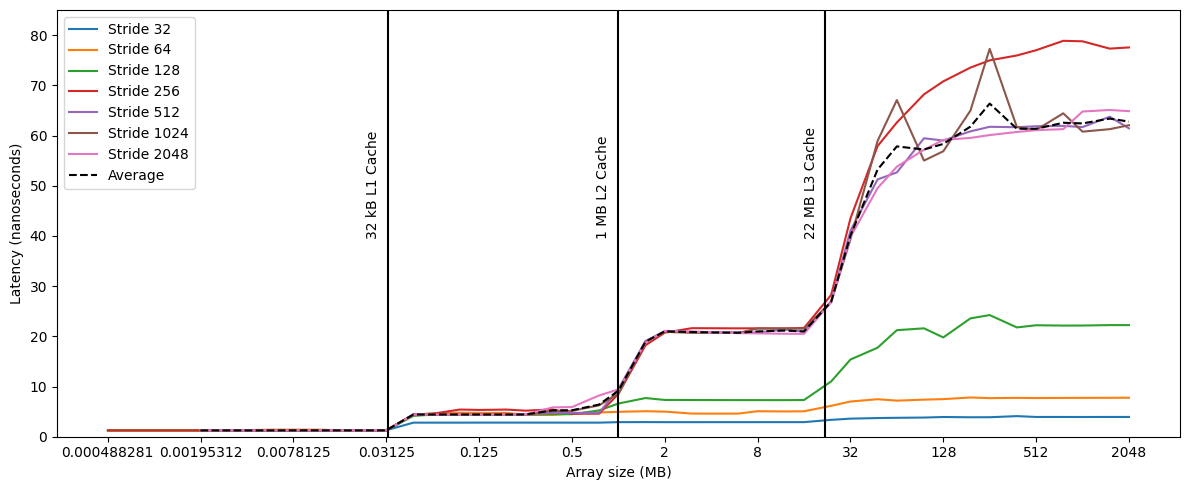

In [3]:
# Initialize an empty dictionary to hold the data for each stride
data = {}

# Open the file and read the data
with open('mem_lat.out', 'r') as f:
    stride = None
    for line in f:
        # Check if this line indicates a new stride
        if line.startswith('"stride='):
            # Extract the stride value
            stride = int(line.split('=')[1])
            # Initialize a new list for this stride
            data[stride] = []
        elif line == '\n':
            # Stride is done, reset it
            stride = None
        elif stride is not None:
            # This line contains data for the current stride
            array_size, latency = map(float, line.split())
            data[stride].append((array_size, latency))

plt.figure(figsize=(12, 5))
ax = plt.subplot(111)

# Plot the data for each stride
for stride, values in data.items():
    # Separate the data into two lists for plotting
    array_sizes, latencies = zip(*values)
    # Plot this stride's data
    plt.plot(array_sizes, latencies, label=f'Stride {stride}')

# Get averages the total average time for the strides 512, 1024 and 2048
results = []
for stride, values in data.items():
    if stride in [512, 1024, 2048]:
        results.append(values)

results = [list(zip(*x)) for x in results]
averages = np.mean([list(x[1]) for x in results], axis=0)
print(np.array(results[0][0]))
print(averages)
plt.plot(results[0][0], averages, label="Average", color="k", linestyle="--")

plt.ylabel("Latency (nanoseconds)")
plt.xlabel("Array size (MB)")
plt.xscale("log", base=2)
# plt.xticks(results[0,:,0],results[0,:,0], rotation=45)
plt.xticks([2**i for i in range(-10,12)])
locmaj = matplotlib.ticker.LogLocator(base=2,numticks=21)
ax.xaxis.set_major_locator(locmaj)
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: '{:g}'.format(y)))

# start, end = ax.get_xlim()
# ax.xaxis.set_ticks(np.arange(0, 2000, 0.1))
# ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))
# ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ymax=85
texty=40
plt.vlines([0.032, 1, 22], 0, ymax, color="k")
plt.text(0.023, texty, "32 kB L1 Cache", rotation=90)
plt.text(.72, texty, "1 MB L2 Cache", rotation=90)
plt.text(16, texty, "22 MB L3 Cache", rotation=90)
plt.axis(ymin=0, ymax=ymax)
plt.legend()
plt.tight_layout()
plt.savefig("mem_lat.pdf")

# Show the plot
plt.show()

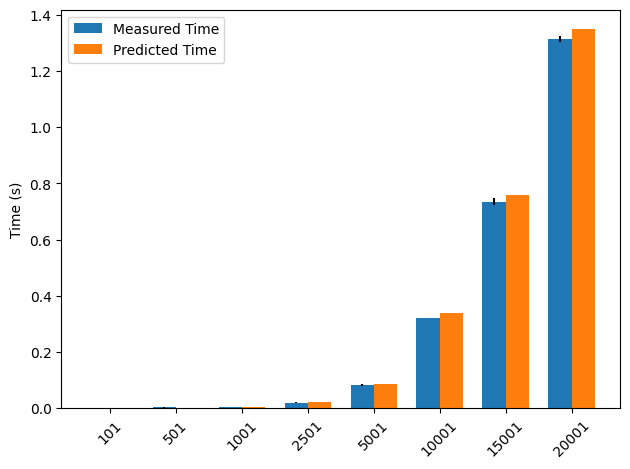

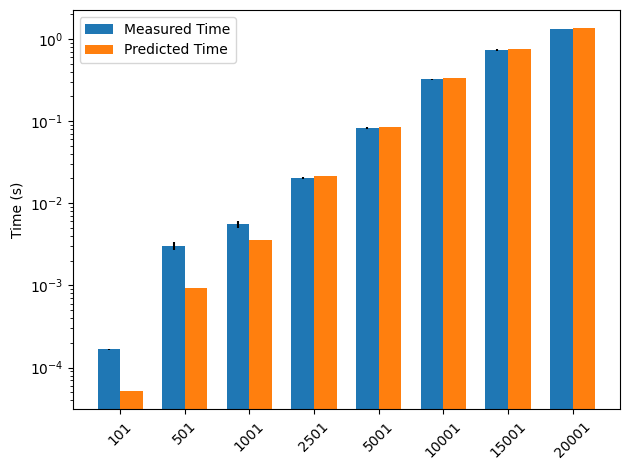

In [10]:
def visualize_csv(filename, log=False):
    df = pd.read_csv(filename)
    df = df.sort_values('nodes')

    fig, ax = plt.subplots()
    bar_width = 0.35

    index = np.arange(len(df['nodes'].unique()))
    averages = df.groupby('nodes')['measured_time'].mean()
    errors = df.groupby('nodes')['measured_time'].std()
    predicted = df.groupby('nodes')['predicted_time'].mean()
    predicted_errors = df.groupby('nodes')['predicted_time'].std()

    ax.bar(index, averages, bar_width, yerr=errors, label='Measured Time')
    ax.bar(index + bar_width, predicted, bar_width, yerr=predicted_errors, label='Predicted Time')

    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(df['nodes'].unique(), rotation=45)
    ax.set_ylabel('Time (s)')
    if log:
        ax.set_yscale('log')
    ax.legend()

    plt.tight_layout()
    plt.savefig(filename.split('.')[0] + ('_log' if log else '') + '.pdf')
    plt.show()

    return df

visualize_csv('bfs_benchmark_star.csv', False)
df = visualize_csv('bfs_benchmark_star.csv', True)

Relative differences: nodes
101      68.941591
501      69.305013
1001     35.857954
2501      5.843878
5001      3.957950
10001     5.465341
15001     3.436413
20001     2.752532
dtype: float64


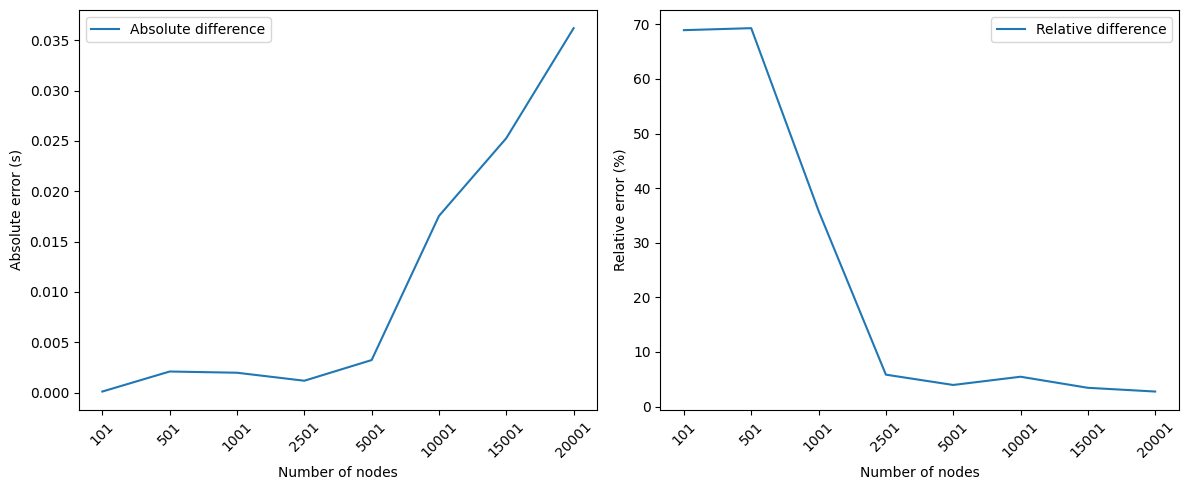

In [17]:
index = np.arange(len(df['nodes'].unique()))
averages = df.groupby('nodes')['measured_time'].mean()
predicted = df.groupby('nodes')['predicted_time'].mean()

# Get the absolute and relative differences between the measured and predicted times
absolute_diff = abs(averages - predicted)
relative_diff = absolute_diff / averages * 100

# print("Absolute differences:", absolute_diff)
print("Relative differences:", relative_diff)

# For each number of nodes, get also the number of edges
edges = df.groupby('nodes')['edges'].mean()
# Add a column to the dataframe with the number of edges divided by the number of nodes
df['edges_per_node'] = df['edges'] / df['nodes']
df.groupby('nodes')['edges_per_node'].mean()

# Plot absolute and relative errors in subplots horizontally
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(index, absolute_diff, label='Absolute difference')
ax[0].set_ylabel('Absolute error (s)')
ax[0].set_xlabel('Number of nodes')
ax[0].set_xticks(index)
ax[0].set_xticklabels(df['nodes'].unique(), rotation=45)
ax[0].legend()

ax[1].plot(index, relative_diff, label='Relative difference')
ax[1].set_ylabel('Relative error (%)')
ax[1].set_xlabel('Number of nodes')
ax[1].set_xticks(index)
ax[1].set_xticklabels(df['nodes'].unique(), rotation=45)
ax[1].legend()

plt.tight_layout()
plt.savefig('bfs_benchmark_star_errors.pdf')
plt.show()
